In [1]:
import numpy as np
import pandas as pd
import math
import sys

import matplotlib.pyplot as plt 
%matplotlib inline

import random as rand
from collections import defaultdict

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA



from time import time

In [2]:
adult_test_df = pd.read_csv('datasets/benchmark/adult_clean_test.csv')
adult_train_df = pd.read_csv('datasets/benchmark/adult_clean_train.csv')
titanic_test_df = pd.read_csv('datasets/benchmark/titanic_clean_test.csv')
titanic_train_df = pd.read_csv('datasets/benchmark/titanic_clean_train.csv')
weather_test_df = pd.read_csv('datasets/benchmark/weatherAUS_clean_test.csv')
weather_train_df = pd.read_csv('datasets/benchmark/weatherAUS_clean_train.csv')
wine_test_df = pd.read_csv('datasets/benchmark/wine_test.csv')
wine_train_df = pd.read_csv('datasets/benchmark/wine_train.csv')

In [3]:
def extract_X_y(df, col_y):
    X = df.drop(col_y, axis=1)
    y = df[col_y]
    return X, y

In [4]:
adult_test_X, adult_test_y = extract_X_y(adult_test_df, 'income_>50k')
adult_train_X, adult_train_y = extract_X_y(adult_train_df, 'income_>50k')

titanic_test_X, titanic_test_y = extract_X_y(titanic_test_df, 'Survived')
titanic_train_X, titanic_train_y = extract_X_y(titanic_train_df, 'Survived')

weather_test_X, weather_test_y = extract_X_y(weather_test_df, 'RainTomorrow')
weather_train_X, weather_train_y = extract_X_y(weather_train_df, 'RainTomorrow')

wine_test_X, wine_test_y = extract_X_y(wine_test_df, 'quality')
wine_train_X, wine_train_y = extract_X_y(wine_train_df, 'quality')

In [5]:
def df_features_to_dicts(df):
    columns = df.columns
    dicts = []
   
    for index, row in df.iterrows():
        feature_dict = {}
        for col in columns:
            feature_dict[col] = row[col]
        dicts.append(feature_dict)
    return dicts

In [6]:
adult_test_dict_X = df_features_to_dicts(adult_test_X)
adult_train_dict_X = df_features_to_dicts(adult_train_X)

titanic_test_dict_X = df_features_to_dicts(titanic_test_X)
titanic_train_dict_X = df_features_to_dicts(titanic_train_X)

weather_test_dict_X = df_features_to_dicts(weather_test_X)
weather_train_dict_X = df_features_to_dicts(weather_train_X)

wine_test_dict_X = df_features_to_dicts(wine_test_X)
wine_train_dict_X = df_features_to_dicts(wine_train_X)

In [7]:
titanic_train_X.shape

(1047, 20)

In [8]:
titanic_train_y.shape

(1047,)

In [9]:
len(titanic_train_dict_X)

1047

In [10]:
def compute_score(model, test_X, test_y):
    pred = model.predict(test_X)
    acc = accuracy_score(pred, test_y)
    f1 = f1_score(pred, test_y)
    conf = confusion_matrix(pred, test_y)

    return acc, f1, conf

In [11]:
def fit_compute_score(model, train_X, train_y, test_X, test_y):
    t0 = time()
    model.fit(train_X, train_y)
    duration = time() - t0
    train_acc, train_f1, train_conf = compute_score(model, train_X, train_y)
    test_acc, test_f1, test_conf = compute_score(model, test_X, test_y)
    print("duration", duration)
    print("train accuracy", train_acc)
    print("train f1", train_f1)
    print("train tn, fp, fn, tp", train_conf.ravel()) 
    print("test accuracy", test_acc)
    print("test f1", test_f1)
    print("test tn, fp, fn, tp", test_conf.ravel())
    print()
    
    return train_acc, train_f1, train_conf, test_acc, test_f1, test_conf

In [18]:
def compare_feature_hashing(train_X, train_dict_X, train_y, test_X, test_dict_X, test_y):
    clf_ridge_default = RidgeClassifier()
    print('ridge_default')
    ridge_default_train_acc, ridge_default_train_f1, ridge_default_train_conf, \
        ridge_default_test_acc, ridge_default_test_f1, ridge_default_test_conf = \
        fit_compute_score(clf_ridge_default, train_X, train_y, test_X, test_y)

    n_estimators = 1000
    clf_randfor_default = RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators)
    print('randfor_default')
    randfor_default_train_acc, randfor_default_train_f1, randfor_default_train_conf, \
        randfor_default_test_acc, randfor_default_test_f1, randfor_default_test_conf = \
        fit_compute_score(clf_randfor_default, train_X, train_y, test_X, test_y)

    ridge_train_acc = []
    ridge_train_f1 = []
    ridge_train_conf = []
    ridge_test_acc = []
    ridge_test_f1 = []
    ridge_test_conf = []
    randfor_train_acc = []
    randfor_train_f1 = []
    randfor_train_conf = []
    randfor_test_acc = []
    randfor_test_f1 = []
    randfor_test_conf = []
    
#     for i in range(1, 30):
#     pca = PCA(n_components=i)
#     pcan = PCA(n_components=i)
#     pca.fit(rain_x_tr)
#     pcan.fit(rain_norm_x_tr)
    
#     clf = lr(penalty='l2').fit(pca.transform(rain_x_tr), rain_y_tr)
#     clfn = lr(penalty='l2').fit(pcan.transform(rain_norm_x_tr), rain_y_tr)
    
#     cmatrices.append(cm(rain_y_te, clf.predict(pca.transform(rain_x_te))))
#     cmatricesn.append(cm(rain_norm_y_te, clfn.predict(pcan.transform(rain_norm_x_te))))
    
#     scores.append(clf.score(pca.transform(rain_x_te_true), rain_y_te_true))
#     scoresn.append(clfn.score(pcan.transform(rain_norm_x_te_true), rain_norm_y_te_true))
    
    t = np.arange(2, 11, 2)
    
    for i in t:
        percent = 0.1*i
        n_features = math.ceil(train_X.shape[1]*percent)
        print("small percent", percent, "n_features", n_features)
        print()
        pca = PCA(n_components=n_features)
        # hasher = FeatureHasher(n_features=n_features)
        train_X_small = pca.fit_transform(train_X)
        test_X_small = pca.transform(test_X)

        clf_ridge_small = RidgeClassifier()
        print('ridge_small')
        ridge_small_train_acc, ridge_small_train_f1, ridge_small_train_conf, \
            ridge_small_test_acc, ridge_small_test_f1, ridge_small_test_conf = \
            fit_compute_score(clf_ridge_small, train_X_small, train_y, test_X_small, test_y)
        ridge_train_acc.append(ridge_small_train_acc)
        ridge_train_f1.append(ridge_small_train_f1)
        ridge_train_conf.append(ridge_small_train_conf)
        ridge_test_acc.append(ridge_small_test_acc)
        ridge_test_f1.append(ridge_small_test_f1)
        ridge_test_conf.append(ridge_small_test_conf)

        clf_randfor_small = RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators)
        print('randfor_small')
        randfor_small_train_acc, randfor_small_train_f1, randfor_small_train_conf, \
            randfor_small_test_acc, randfor_small_test_f1, randfor_small_test_conf = \
            fit_compute_score(clf_randfor_small, train_X_small, train_y, test_X_small, test_y)
        randfor_train_acc.append(randfor_small_train_acc)
        randfor_train_f1.append(randfor_small_train_f1)
        randfor_train_conf.append(randfor_small_train_conf)
        randfor_test_acc.append(randfor_small_test_acc)
        randfor_test_f1.append(randfor_small_test_f1)
        randfor_test_conf.append(randfor_small_test_conf)

    fig, ax = plt.subplots(2, 2, figsize=(15,10), tight_layout=True)
    
    ax[0,0].plot(t, ridge_default_train_acc*np.ones(5), label='ridge_default')
    ax[0,0].plot(t, randfor_default_train_acc*np.ones(5), label='randfor_default')
    ax[0,0].plot(t, ridge_train_acc, label='ridge_small')
    ax[0,0].plot(t, randfor_train_acc, label='randfor_small')
    ax[0,0].set(xlabel='features', ylabel='accuracy', title='train')
    ax[0,0].legend()

    ax[0,1].plot(t, ridge_default_test_acc*np.ones(5), label='ridge_default')
    ax[0,1].plot(t, randfor_default_test_acc*np.ones(5), label='randfor_default')
    ax[0,1].plot(t, ridge_test_acc, label='ridge_small')
    ax[0,1].plot(t, randfor_test_acc, label='randfor_small')
    ax[0,1].set(xlabel='features', ylabel='accuracy', title='test')
    ax[0,1].legend()
    
    ax[1,0].plot(t, ridge_default_train_f1*np.ones(5), label='ridge_default')
    ax[1,0].plot(t, randfor_default_train_f1*np.ones(5), label='randfor_default')
    ax[1,0].plot(t, ridge_train_f1, label='ridge_small')
    ax[1,0].plot(t, randfor_train_f1, label='randfor_small')
    ax[1,0].set(xlabel='features', ylabel='f1', title='train')
    ax[1,0].legend()
    
    ax[1,1].plot(t, ridge_default_test_f1*np.ones(5), label='ridge_default')
    ax[1,1].plot(t, randfor_default_test_f1*np.ones(5), label='randfor_default')
    ax[1,1].plot(t, ridge_test_f1, label='ridge_small')
    ax[1,1].plot(t, randfor_test_f1, label='randfor_small')
    ax[1,1].set(xlabel='features', ylabel='f1', title='test')
    ax[1,1].legend()

    plt.show()

ridge_default
duration 0.10300064086914062
train accuracy 0.8433445089959819
train f1 0.6108462076419353
train tn, fp, fn, tp [28148  4476  1645  4804]
test accuracy 0.8356024158050978
test f1 0.6044334975369458
test tn, fp, fn, tp [6936 1180  426 1227]

randfor_default
duration 16.635756492614746
train accuracy 0.9999488137588616
train f1 0.9998922413793103
train tn, fp, fn, tp [29792     1     1  9279]
test accuracy 0.8558706111167981
test f1 0.678097850937357
test tn, fp, fn, tp [6878  924  484 1483]

small percent 0.2 n_features 19

ridge_small
duration 0.03299236297607422
train accuracy 0.835052337931564
train f1 0.5765161968591892
train tn, fp, fn, tp [28241  4893  1552  4387]
test accuracy 0.8267990582454704
test f1 0.5690269994905758
test tn, fp, fn, tp [6960 1290  402 1117]

randfor_small
duration 22.912691593170166
train accuracy 0.9999488137588616
train f1 0.9998922413793103
train tn, fp, fn, tp [29792     1     1  9279]
test accuracy 0.8562800696079435
test f1 0.67150210575

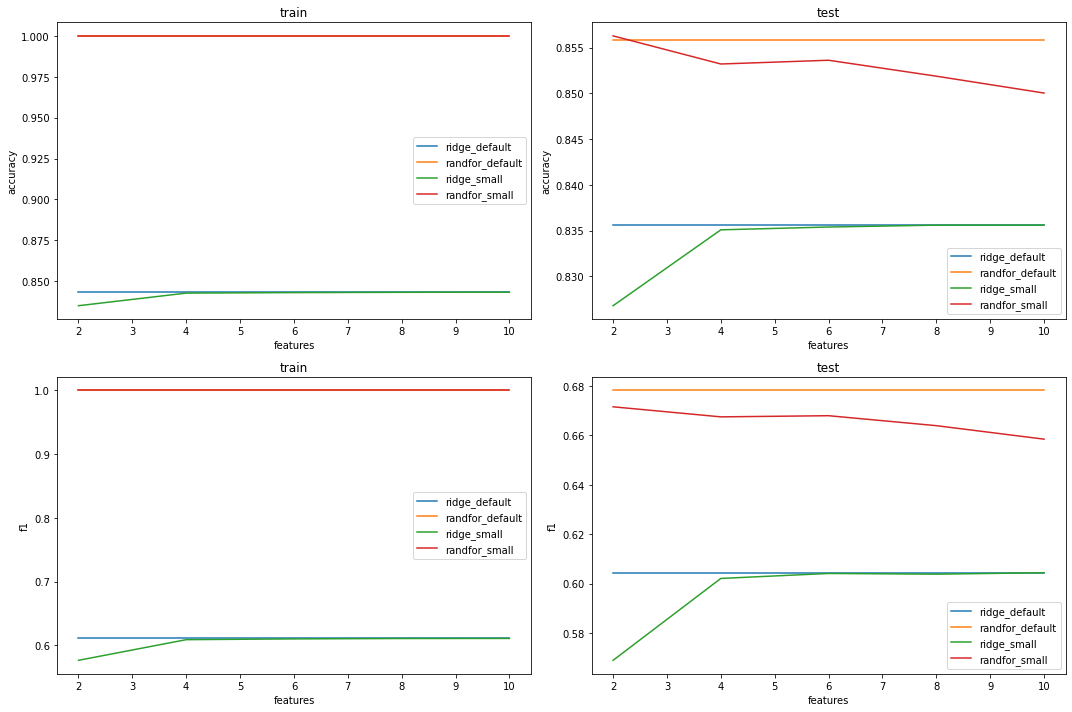

In [19]:
compare_feature_hashing(adult_train_X, adult_train_dict_X, adult_train_y, adult_test_X, adult_test_dict_X, adult_test_y)

ridge_default
duration 0.00600123405456543
train accuracy 0.8538681948424068
train f1 0.7994757536041939
train tn, fp, fn, tp [589  83  70 305]
test accuracy 0.8664122137404581
test f1 0.8223350253807108
test tn, fp, fn, tp [146  25  10  81]

randfor_default
duration 1.3110032081604004
train accuracy 0.9808978032473734
train f1 0.9739583333333334
train tn, fp, fn, tp [653  14   6 374]
test accuracy 0.8244274809160306
test f1 0.7628865979381443
test tn, fp, fn, tp [142  32  14  74]

small percent 0.2 n_features 4

ridge_small
duration 0.002001523971557617
train accuracy 0.7172874880611271
train f1 0.4825174825174825
train tn, fp, fn, tp [613 250  46 138]
test accuracy 0.683206106870229
test f1 0.47133757961783435
test tn, fp, fn, tp [142  69  14  37]

randfor_small
duration 1.4193756580352783
train accuracy 0.9808978032473734
train f1 0.9739583333333334
train tn, fp, fn, tp [653  14   6 374]
test accuracy 0.7900763358778626
test f1 0.7342995169082124
test tn, fp, fn, tp [131  30  25  76

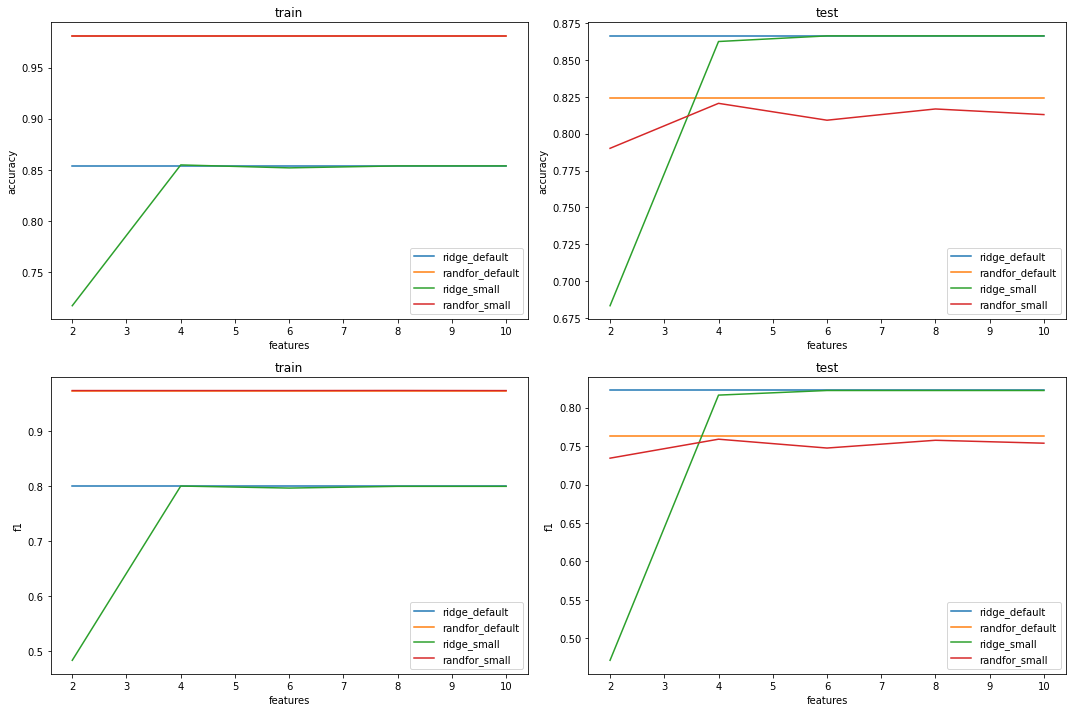

In [20]:
compare_feature_hashing(titanic_train_X, titanic_train_dict_X, titanic_train_y, titanic_test_X, titanic_test_dict_X, titanic_test_y)

ridge_default


C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


duration 0.08100175857543945
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]

randfor_default


C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


duration 7.701581001281738
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]

small percent 0.2 n_features 6

ridge_small


C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


duration 0.03200268745422363
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]

randfor_small


C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


duration 7.672375202178955
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]

small percent 0.4 n_features 12

ridge_small


C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


duration 0.03699326515197754
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]

randfor_small


C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


duration 7.554589509963989
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]

small percent 0.6000000000000001 n_features 18

ridge_small


C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


duration 0.05299973487854004
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]

randfor_small


C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


duration 7.562875986099243
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]

small percent 0.8 n_features 24

ridge_small


C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


duration 0.0599980354309082
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]

randfor_small


C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


duration 7.580167055130005
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]

small percent 1.0 n_features 29

ridge_small


C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


duration 0.07100129127502441
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]

randfor_small


C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


duration 7.567278861999512
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]



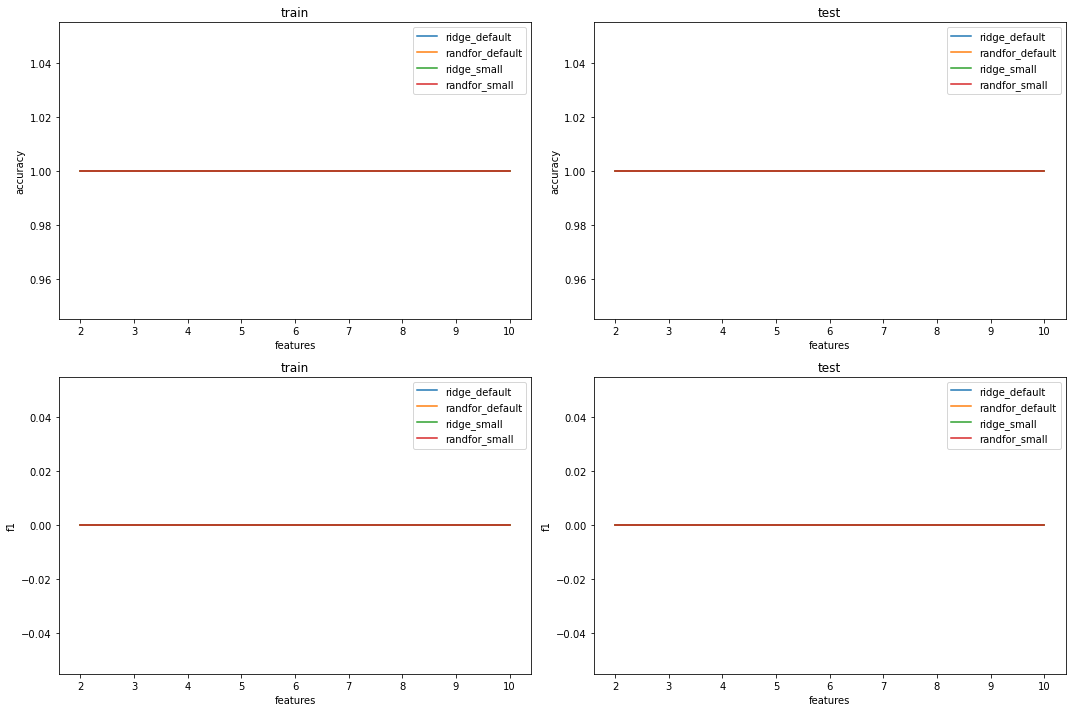

In [21]:
compare_feature_hashing(weather_train_X, weather_train_dict_X, weather_train_y, weather_test_X, weather_test_dict_X, weather_test_y)

ridge_default
duration 0.005997419357299805
train accuracy 0.7490226739640344
train f1 0.7602688573562361
train tn, fp, fn, tp [449 174 147 509]
test accuracy 0.740625
test f1 0.7446153846153846
test tn, fp, fn, tp [116  51  32 121]

randfor_default
duration 1.423492670059204
train accuracy 1.0
train f1 1.0
train tn, fp, fn, tp [596   0   0 683]
test accuracy 0.8125
test f1 0.8192771084337349
test tn, fp, fn, tp [124  36  24 136]

small percent 0.2 n_features 3

ridge_small
duration 0.0019998550415039062
train accuracy 0.6231430805316653
train f1 0.7057387057387057
train tn, fp, fn, tp [219 105 377 578]
test accuracy 0.64375
test f1 0.7178217821782177
test tn, fp, fn, tp [ 61  27  87 145]

randfor_small
duration 1.4216296672821045
train accuracy 1.0
train f1 1.0
train tn, fp, fn, tp [596   0   0 683]
test accuracy 0.7625
test f1 0.7764705882352941
test tn, fp, fn, tp [112  40  36 132]

small percent 0.4 n_features 5

ridge_small
duration 0.0019996166229248047
train accuracy 0.728694292

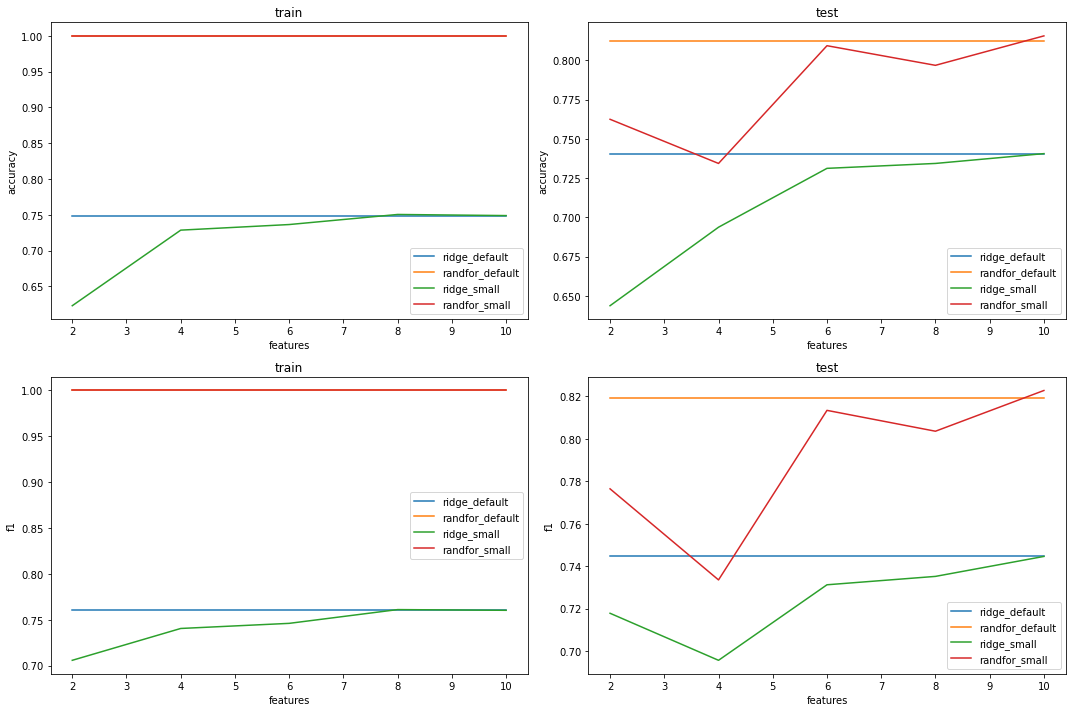

In [22]:
compare_feature_hashing(wine_train_X, wine_train_dict_X, wine_train_y, wine_test_X, wine_test_dict_X, wine_test_y)